In [2]:
import numpy as np
import matplotlib as mp
import ccdproc,os,sys,time,random
from glob import glob
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
import astroalign as aa
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.ticker import LogLocator
from astropy.stats import SigmaClip, mad_std
from photutils.background import Background2D, MeanBackground,SExtractorBackground
from photutils import find_peaks, CircularAperture, CircularAnnulus, aperture_photometry
from photutils.centroids import centroid_2dg
from astropy.stats import SigmaClip, mad_std
from photutils import Background2D, MedianBackground, DAOStarFinder,IRAFStarFinder
from photutils.utils import calc_total_error
#from photutils.detection import findstars
from photutils.detection import DAOStarFinder
import glob ,re
import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_11540/3717850854.py:17: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_peaks` to silence this warning.
  from photutils import find_peaks, CircularAperture, CircularAnnulus, aperture_photometry
/tmp/ipykernel_11540/3717850854.py:17: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import find_peaks, CircularAperture, CircularAnnulus, aperture_photometry
/tmp/ipykernel_11540/3717850854.py:17: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.aperture.CircularAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAnnulus` to silence this 

In [3]:
#from ginga.web.pgw import ipg
#use_opencv = False

#server = make_server(host='/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/', port=9991, use_opencv=use_opencv)
#server.start(no_ioloop=True)


#put location of your files
dir="/home/osama/Downloads/ARIES/Test/"
fnames1= sorted(glob.iglob(dir+'/DATA_1.3mDFOT_Osama/science_aligned_*.fits'),key=lambda f: int(re.sub('\D', '', f)))

In [4]:
data,header=fits.getdata('/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_cln_1.fits',header=True)
exposure=header['EXPOSURE']
data=data[600:1200,600:1200]
mean, median, std = sigma_clipped_stats(data, sigma=3.0, maxiters=20)
print(mean,median,std)

nan nan nan


In [5]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (100, 100), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

ValueError: data must be a 2D array.

# Apperture Photometry

Filename: /home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   (2048, 2048)   float32   


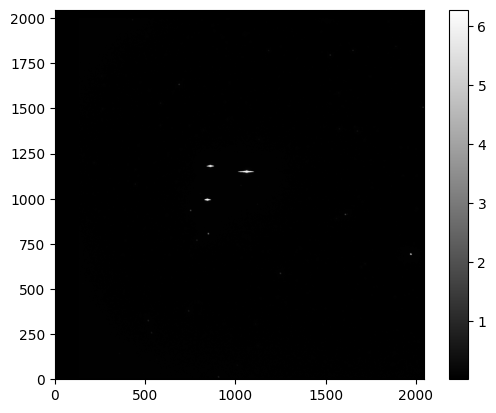

In [8]:
from astropy.io import fits
import pylab as plt
from matplotlib.colors import LogNorm
%matplotlib inline
file = fits.open('~/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_5.fits')
file.info()
data = file[0].data
data

plt.imshow(data, cmap='gray', origin='lower',)# norm= LogNorm())
plt.colorbar()

In [9]:
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
bkg_sigma = mad_std(data)  
daofind = DAOStarFinder(fwhm=4.0, threshold=3.0 * bkg_sigma)  
sources = daofind(data)

In [10]:
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)


 id  xcentroid ycentroid sharpness  ... sky     peak       flux        mag     
---- --------- --------- ---------- ... --- ----------- --------- -------------
   1 1.5704267 1.5704267 0.24378076 ...   0  0.04353999 12.645645    -2.7548525
   2 2045.4184 1.6343948 0.22059076 ...   0  0.04222301  12.70145    -2.7596333
   3 150.07169 3.7459257 0.57557205 ...   0 0.056733996 1.4224746   -0.38261132
   4 157.22026 4.0178142 0.53670524 ...   0 0.057336766 1.5875294   -0.50180446
   5  672.8293 4.6450737 0.56470668 ...   0 0.048131842 1.0893807  -0.092949233
   6  447.2077 5.1550338 0.39310027 ...   0 0.046787277 1.0841432  -0.087716587
   7 1536.5805 5.1440116 0.27483156 ...   0 0.044633321  1.012869  -0.013883199
   8 395.76779 5.5910957  0.5185388 ...   0 0.049101356  1.006519 -0.0070549005
   9 1036.0582 6.5234994 0.67630422 ...   0 0.046975795 1.0928283  -0.096379806
  10 1499.6097 5.7810836 0.26676378 ...   0 0.045452971 1.1484303   -0.15026165
 ...       ...       ...        ... ... 

In [11]:
data,header=fits.getdata('science_aligned_5.fits',header=True)
exposure=header['EXPOSURE']
data=data[600:1200,600:1200]
mean, median, std = sigma_clipped_stats(data, sigma=3.0, maxiters=20)
print(mean,median,std)

FileNotFoundError: [Errno 2] No such file or directory: 'science_aligned_5.fits'

In [12]:
import numpy as np
from photutils.aperture import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=4.0)  
phot_table = aperture_photometry(data, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id   xcenter   ycenter  aperture_sum
        pix       pix                
---- --------- --------- ------------
   1 1.5704267 1.5704267    1.4213126
   2 2045.4184 1.6343948    1.4291437
   3 150.07169 3.7459257    2.7135369
   4 157.22026 4.0178142     2.708877
   5  672.8293 4.6450737    2.2829693
   6  447.2077 5.1550338    2.2444759
   7 1536.5805 5.1440116    2.1871968
   8 395.76779 5.5910957    2.3367773
   9 1036.0582 6.5234994    2.1994234
  10 1499.6097 5.7810836    2.1939785
 ...       ...       ...          ...
9704 923.35697  1993.616    2.1866921
9705 1428.2831 1993.2762    2.1732487
9706 1862.5546 1993.0837    2.1896713
9707 1969.0697 1992.8404    2.1830217
9708 540.25262 1993.9582     2.201107
9709 783.85231 1993.9338    2.1828065
9710 1038.9562 1994.3015     2.187825
9711 1507.8716 1993.5529    2.2096508
9712 1.5704267 2045.4296    1.4213126
9713 2045.4296 2045.4296    1.4213126
Length = 9713 rows


 ...]

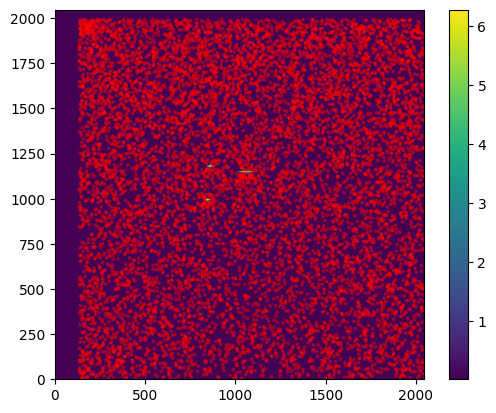

In [13]:
import matplotlib.pyplot as plt
plt.imshow(data, cmap='viridis', origin='lower')
plt.colorbar()
apertures.plot(color='red', lw=1.5, alpha=0.5)

In [ ]:
'''
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(section1, sigma=3.0)  

#from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
mask = np.zeros(data.shape, dtype=bool)
mask[150:190, 10:28] = True
mask[0:28, 150:180] = True
sources = daofind(section1 - median, mask=mask,)
#plt.imshow(sources)
'''

'\nfrom astropy.stats import sigma_clipped_stats\nmean, median, std = sigma_clipped_stats(section1, sigma=3.0)  \n\n#from photutils.detection import DAOStarFinder\ndaofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)\nmask = np.zeros(data.shape, dtype=bool)\nmask[150:190, 10:28] = True\nmask[0:28, 150:180] = True\nsources = daofind(section1 - median, mask=mask,)\n#plt.imshow(sources)\n'

In [14]:
from astropy.stats import sigma_clipped_stats
#from photutils.datasets import make_100gaussians_image
from photutils.detection import find_peaks
#data = make_100gaussians_image()
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
threshold = median + (5.0 * std)
tbl = find_peaks(data, threshold, box_size=11)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(tbl[:10])

x_peak y_peak  peak_value
------ ------ -----------
   135      0 0.061006099
   147      0  0.05721885
   498      0 0.055423584
   167      3 0.054798659
   157      4 0.057900552
   396      6 0.050185893
   135      8 0.060457729
  1522      8 0.088952526
   906      9  0.97032523
   148     11 0.058820952


(0.0, 2047.0)

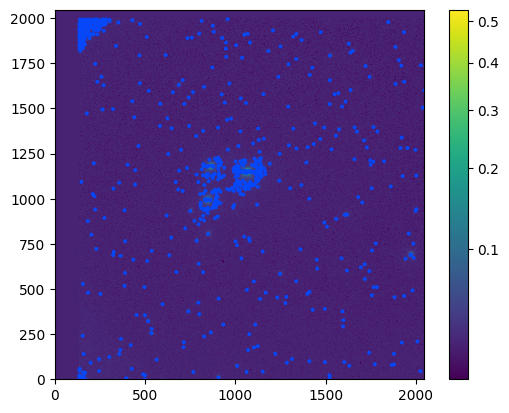

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=5.0)
norm = simple_norm(data, 'sqrt', percent=99.9)
plt.imshow(data, cmap='viridis', origin='lower', norm=norm,
           interpolation='nearest')
plt.colorbar()
apertures.plot(color='#0547f9', lw=1.5)
plt.xlim(0, data.shape[1] - 1)
plt.ylim(0, data.shape[0] - 1)

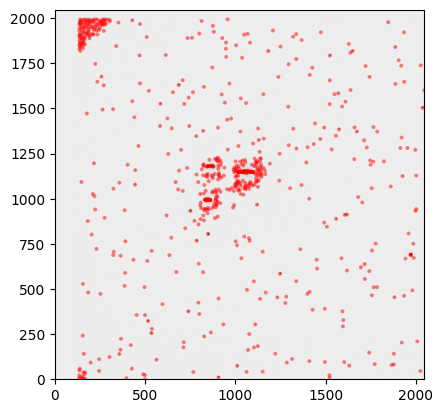

In [16]:
# define positions based on peak table and plot data
peak_positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
plt.imshow(data, cmap = 'Greys', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')

# plot peak apertures
peak_apertures = CircularAperture(peak_positions, r = 5.0)
peak_apertures.plot(color = 'red', lw = 1.5, alpha = 0.5);

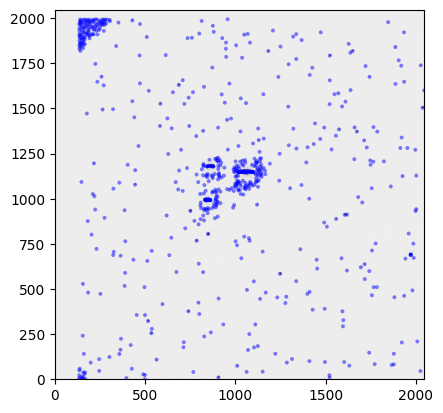

In [18]:
# import tools
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry

# define annuluses
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

# plot annuluses
plt.figure()
plt.imshow(data, cmap='Greys', norm = LogNorm(), origin = 'lower')
apertures.plot(color='blue',lw=1.5, alpha = 0.5)
#annulus_aperture.plot(color='green',lw=1.5,alpha=0.5)
plt.show()

In [ ]:
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry
# define background
aperstats = ApertureStats(data, annulus_aperture)
bkg_mean = aperstats.mean
aperture_area = apertures.area_overlap(data)
total_bkg = bkg_mean*aperture_area

# perform aperture photometry
star_data = aperture_photometry(data, apertures)

# add backgrounds to table
star_data['total_bkg'] = total_bkg

# format and print data
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'
star_data.pprint()

 id xcenter ycenter aperture_sum total_bkg
      pix     pix                         
--- ------- ------- ------------ ---------
  1     135       0    2.2752589 2.1925628
  2     147       0    2.3980954 2.3758366
  3     498       0    2.2251616 2.0056218
  4     167       3    3.6762388 3.5822848
  5     157       4    4.1371759  4.020078
  6     396       6    3.6333599 3.5281948
  7     135       8    4.0028919 3.8551708
  8    1522       8    3.5323499 3.5090619
  9     906       9    34.869235 3.7866548
 10     148      11    4.2517534 4.1748933
...     ...     ...          ...       ...
665     191    1992    4.2152323  3.959203
666     215    1992    4.1106805 3.8929945
667     235    1992    4.0166856 3.8134942
668     140    1993    4.2677422 3.8342546
669     165    1993    4.1406487 3.9939884
670     263    1993    3.7801905 3.6866464
671     273    1993    3.7489835 3.6530554
672     288    1993    3.7080853 3.6060701
673     226    1994    3.8469245 3.8050089
674     957

In [ ]:
!pip install acstools

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 1.0 MB/s eta 0:00:00 0:00:01
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
from acstools import acszpt

date = '2024-01-19'

#instrument = 'WFC'

#filter = 'F814W'

# fetch zeropoint from catalogue
q = acszpt.Query(date = date, detector = instrument)
zpt_table = q.fetch()
q_filter = acszpt.Query(date = date, detector = instrument, filt = filter)
filter_zpt = q_filter.fetch()

# print data
print(filter_zpt)

AttributeError: type object 'filter' has no attribute 'upper'

In [ ]:

# use ABmag from filter_zpt
zeropoint = 25.948

# find exposure time in header
extime = 1800

# calculate magnitudes
import math
magnitudes = []
for line in star_data:
    magnitudes.append(zeropoint - (2.5*math.log10(abs(line[3]-line[4])/extime)))

# add magnitudes to table and print data
star_data['magnitude'] = magnitudes
star_data.pprint(max_lines = -1, max_width = -1)

 id xcenter ycenter aperture_sum total_bkg     magnitude     
      pix     pix                                            
--- ------- ------- ------------ --------- ------------------
  1     135       0    2.2752589 2.1925628  36.79246859754117
  2     147       0    2.3980954 2.3758366 38.217431059255006
  3     498       0    2.2251616 2.0056218 35.732398014957916
  4     167       3    3.6762388 3.5822848  36.65389304545636
  5     157       4    4.1371759  4.020078  36.41480852667044
  6     396       6    3.6333599 3.5281948   36.5315023982811
  7     135       8    4.0028919 3.8551708 36.162575381482156
  8    1522       8    3.5323499 3.5090619  38.16835366643584
  9     906       9    34.869235 3.7866548  30.35488861039467
 10     148      11    4.2517534 4.1748933   36.8719279227679
 11     155      14    4.0639565 4.0861289  38.22164650276693
 12     135      22    3.9500497 3.8151506   36.2611587945534
 13    1521      22     4.275894 3.4500112   34.2938851738181
 14     

In [ ]:
# Define the list of FITS file paths
from astropy.io import fits
dir=('/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama')
fits_files = []
for i in range(1,11,1):
    fits_files.append(f'/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_{i}.fits')

print(fits_files)



['/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_1.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_2.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_3.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_4.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_5.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_6.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_7.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_8.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_9.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_10.fits']


In [ ]:
#fits_files=['/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_1.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_2.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_3.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_4.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_5.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_6.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_7.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_8.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_9.fits', '/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_10.fits']
fits_data = []

for fits_file in fits_files:
    file_data = fits.open(fits_file)
    image_data = file_data[0].data
   
    fits_data.append(image_data)

print(fits_data[0:10])


[array([[0.2114023 , 0.2114023 , 0.2114023 , ..., 0.20411143, 0.20451935,
        0.20251696],
       [0.2114023 , 0.2114023 , 0.2114023 , ..., 0.20389107, 0.20977835,
        0.20923094],
       [0.2114023 , 0.2114023 , 0.2114023 , ..., 0.20104057, 0.20454746,
        0.20558688],
       ...,
       [0.2114023 , 0.2114023 , 0.2114023 , ..., 0.2114023 , 0.2114023 ,
        0.2114023 ],
       [0.2114023 , 0.2114023 , 0.2114023 , ..., 0.2114023 , 0.2114023 ,
        0.2114023 ],
       [0.2114023 , 0.2114023 , 0.2114023 , ..., 0.2114023 , 0.2114023 ,
        0.2114023 ]], dtype=float32), array([[0.2093169 , 0.20347036, 0.20556253, ..., 0.1771792 , 0.18454325,
        0.18049343],
       [0.2111891 , 0.21130525, 0.20900454, ..., 0.1760749 , 0.17684324,
        0.17842859],
       [0.21675698, 0.21331438, 0.21069825, ..., 0.17223547, 0.1747676 ,
        0.17412551],
       ...,
       [0.21165511, 0.21666667, 0.22202986, ..., 0.17225264, 0.1750103 ,
        0.16569227],
       [0.21855895

In [ ]:
# Define the list of FITS file paths
from astropy.io import fits
dir=('/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama')
fits_files = [dir+'/science_aligned_10.fits']

#for i in range(0, 10, 1):
    #fits_files.append(dir+'/science_aligned_{i}.fits')

#for i in range(0, 10, 1):
  #  fits_files.append(f'~/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_{i}.fits')
    
print(fits_files)

['/home/osama/Downloads/ARIES/Test/DATA_1.3mDFOT_Osama/science_aligned_10.fits']


In [ ]:
# collect data from fits files
fits_data = []
    
for fits_file in fits_files:
    file_data = fits.open(fits_file)
    image_data = file_data[0].data
   
    fits_data.append(image_data)

print(fits_data[0:10])

[array([[0.2114023 , 0.2114023 , 0.2114023 , ..., 0.20411143, 0.20451935,
        0.20251696],
       [0.2114023 , 0.2114023 , 0.2114023 , ..., 0.20389107, 0.20977835,
        0.20923094],
       [0.2114023 , 0.2114023 , 0.2114023 , ..., 0.20104057, 0.20454746,
        0.20558688],
       ...,
       [0.2114023 , 0.2114023 , 0.2114023 , ..., 0.2114023 , 0.2114023 ,
        0.2114023 ],
       [0.2114023 , 0.2114023 , 0.2114023 , ..., 0.2114023 , 0.2114023 ,
        0.2114023 ],
       [0.2114023 , 0.2114023 , 0.2114023 , ..., 0.2114023 , 0.2114023 ,
        0.2114023 ]], dtype=float32), array([[0.2093169 , 0.20347036, 0.20556253, ..., 0.1771792 , 0.18454325,
        0.18049343],
       [0.2111891 , 0.21130525, 0.20900454, ..., 0.1760749 , 0.17684324,
        0.17842859],
       [0.21675698, 0.21331438, 0.21069825, ..., 0.17223547, 0.1747676 ,
        0.17412551],
       ...,
       [0.21165511, 0.21666667, 0.22202986, ..., 0.17225264, 0.1750103 ,
        0.16569227],
       [0.21855895

In [ ]:


# define position of star and aperture and annulus
from photutils.aperture import CircularAperture, CircularAnnulus

position = [500.03, 2000.81]
aperture = CircularAperture(position,r=5.0)
annulus_aperture = CircularAnnulus(position, r_in=10, r_out=15)



In [ ]:
# perform aperture photometry on selected star for each fits file
from photutils.aperture import aperture_photometry, ApertureStats

star_data = []

for file in fits_data:
    # define background
    aperstats = ApertureStats(file, annulus_aperture)
    bkg_mean = aperstats.mean
    aperture_area = aperture.area_overlap(file)
    total_bkg = bkg_mean*aperture_area
    
    # append aperture sum minus total background
    star_data.append(aperture_photometry(file,aperture)['aperture_sum']-total_bkg)
    
print(star_data[0:10])

[<Column name='aperture_sum' dtype='float64' length=1>
0.03229835078784404, <Column name='aperture_sum' dtype='float64' length=1>
-0.002122514203406922, <Column name='aperture_sum' dtype='float64' length=1>
0.02447243968832602, <Column name='aperture_sum' dtype='float64' length=1>
0.007754964685396715, <Column name='aperture_sum' dtype='float64' length=1>
-0.018984670125146152, <Column name='aperture_sum' dtype='float64' length=1>
0.006376555781844928, <Column name='aperture_sum' dtype='float64' length=1>
0.009380277663705527, <Column name='aperture_sum' dtype='float64' length=1>
0.016461894940507094, <Column name='aperture_sum' dtype='float64' length=1>
0.005616438174627092, <Column name='aperture_sum' dtype='float64' length=1>
-0.01585455177823203]


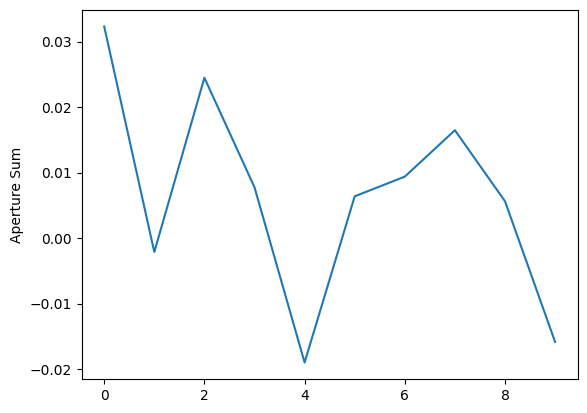

In [ ]:
#plot aperture sums
import matplotlib.pyplot as plt
plt.plot(star_data)
plt.ylabel('Aperture Sum')
plt.show()

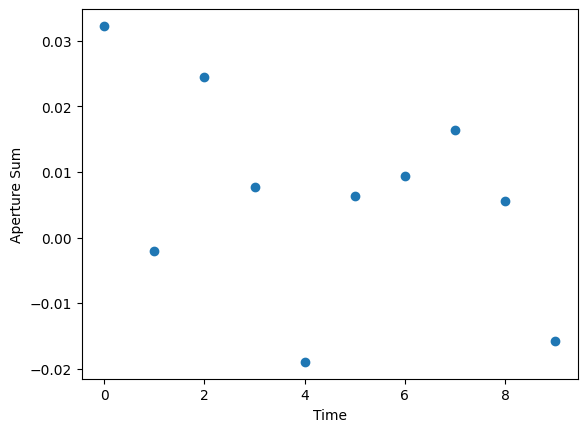

In [ ]:
#plot aperture sums
import matplotlib.pyplot as plt
plt.plot(star_data, 'o')
plt.ylabel('Aperture Sum')
plt.xlabel('Time')
plt.show()

In [ ]:
S1=[]
S2=[]
S3=[]
S4=[]
msky_1=[]
def aperture():
    bg_files = sorted(glob.glob("science_aligned_*.fits"))
    
    
    ll = len(bg_files)
    print(ll)

    if os.path.exists("img")==True:
        pass
    else:
        os.mkdir("img")
    

    coord= [969.8,783.8] #[float(input("source x=")),float(input("source y="))]
    C1 =  [908.6,741.8] #[float(input("C1 x=")),float(input("C1 y="))]   #[411.6,651.89] --4
    C2 = [768.2,656.6] #[float(input("C2 x=")),float(input("C2 y="))]  # [377.58,593.56] --11
    C3 = [924.2,968.6]
    for q in range(ll):
        print(q)
        df1=[]
        df2=[]
        df3=[]
        df4=[]
        file_bg=fits.open(bg_files[q])
        print(bg_files[q])
        data_bkg = file_bg[0].data
        header=file_bg[0].header
        
        mean, median, std = sigma_clipped_stats(data_bkg, sigma=3.0, maxiters= 10)  

        sigma_clip = SigmaClip(sigma=3.)
        bkg_estimator = MeanBackground()
        bkg = Background2D(data_bkg,(10, 10), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        back=bkg.background
        data = data_bkg-back
        bkg2 = Background2D(data,(10, 10), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        back2 = bkg2.background
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
        #print('background has been eliminated')
        fwhm=2.5
        daofind = DAOStarFinder(fwhm=fwhm, threshold=3.0*std)
        sources = daofind(data - median)    

        for col in sources.colnames:
            sources[col].info.format = '%.8g'  # for consistent table output'   
        positions=np.transpose((sources['xcentroid'], sources['ycentroid']))
        px,py= sources['xcentroid'],sources['ycentroid']


        for i in range(len(positions)):
            r1 = np.sqrt(((coord[0] - positions[i][0])**2)+((coord[1] - positions[i][1])**2))
            r2 = np.sqrt(((C1[0] - positions[i][0])**2)+((C1[1] - positions[i][1])**2))
            r3 = np.sqrt(((C2[0] - positions[i][0])**2)+((C2[1] - positions[i][1])**2))
            r4 = np.sqrt(((C3[0] - positions[i][0])**2)+((C3[1] - positions[i][1])**2))
            df1.append(r1)
            df2.append(r2)
            df3.append(r3)
            df4.append(r4)
        a1 = pd.Series(df1).idxmin()
        a2 = pd.Series(df2).idxmin()
        a3 = pd.Series(df3).idxmin()
        a4 = pd.Series(df4).idxmin()
        
        pop1=positions[a1]
        pop2=positions[a2]
        pop3=positions[a3]
        pop4=positions[a4]
        radii = np.arange(2,15,0.2)
        A1 = [CircularAperture(pop1, r=rd) for rd in radii]
        A2 = [CircularAperture(pop2, r=rd) for rd in radii]
        A3 = [CircularAperture(pop3, r=rd) for rd in radii]
        A4 = [CircularAperture(pop4, r=rd) for rd in radii]

        
        colors=['maroon','salmon','yellow','blue','cyan']
        plt.figure(figsize=(7,7))
        plt.imshow(data,cmap='gray',origin='lower',vmin=mean-6*std,vmax=mean+16*std)   #data[x1:x2,y1:y2] [100:370,70:350]
        lt = 30      #int(2.5*fwhm)
        A1[lt].plot(color=colors[0], alpha=0.7)
        A2[lt].plot(color=colors[0], alpha=0.7)
        A3[lt].plot(color=colors[0], alpha=0.7)
        A4[lt].plot(color=colors[0], alpha=0.7)
        
        
        stng = bg_files[q].replace("fits","png")
        
               
        r1_in = lt+8 #int(5*fwhm)
        r1_out = r1_in+5 #int(6*fwhm)
        
        phot_table = aperture_photometry(data,A1)
        annul_apt_1 = CircularAnnulus(pop1,radii[r1_in],radii[r1_out])
        bkg_stats_1 = ApertureStats(data,annul_apt_1,sigma_clip=sigma_clip)
        #annul_apt_1.plot(color=colors[2], alpha=0.4)
        
        annul_apt_2 = CircularAnnulus(pop2,radii[r1_in],radii[r1_out])
        bkg_stats_2 = ApertureStats(data,annul_apt_2,sigma_clip=sigma_clip) 
        
        annul_apt_3 = CircularAnnulus(pop3,radii[r1_in],radii[r1_out])
        bkg_stats_3 = ApertureStats(data,annul_apt_3,sigma_clip=sigma_clip)
        
        annul_apt_4 = CircularAnnulus(pop4,radii[r1_in],radii[r1_out])
        bkg_stats_4 = ApertureStats(data,annul_apt_4,sigma_clip=sigma_clip)
        
        back= ccdproc.CCDData(back2, unit=u.adu)
        err2 = np.array( ccdproc.create_deviation(back,gain = 3*u.electron/u.adu, readnoise =10*u.electron))  #data, gain=1.5 * u.electron/u.adu,readnoise=5 * u.electron)
        error2 = calc_total_error(data, err2 ,effective_gain=3)
        
        a = lt #int(input("enter the radius index :"))
        AS1 = ApertureStats(data,A1[a],local_bkg=bkg_stats_1.median,error =error2)
        AS2 = ApertureStats(data,A2[a],local_bkg=bkg_stats_2.median,error =error2)
        AS3 = ApertureStats(data,A3[a],local_bkg=bkg_stats_3.median,error =error2)
        AS4 = ApertureStats(data,A4[a],local_bkg=bkg_stats_4.median,error =error2)
        
        my_path= "img/"
        print(stng)
        plt.savefig(my_path+stng)
        
        plt.show()
        
        columns = ('xcentroid','ycentroid', 'mean', 'median', 'std','fwhm', 'sum','sum_aper_area','sum_err')
        stats_table_1 = AS1.to_table(columns)
        stats_table_2 = AS2.to_table(columns)
        stats_table_3 = AS3.to_table(columns)
        stats_table_4 = AS4.to_table(columns)
        S1.append(stats_table_1)
        S2.append(stats_table_2)
        S3.append(stats_table_3)
        S4.append(stats_table_4)
        msky_1.append(bkg_stats_1.median)
                  

    return()


In [ ]:
def merr(x,xrr):
    merr = 1.0857*float(xrr)/float(x)
    return(merr)

def magg(flx):
    y = -2.5*np.log10(flx/exposure)
    return(y)

def serr3(x1,x2,x3):
    sigma3 = (np.sqrt(x1**2+x2**2+x3**3))
    return(sigma3)

def serr2(x1,x2):
    sigma2 = (np.sqrt(x1**2+x2**2))/2
    return(sigma2)

def calcmeanerr(array):
    n = len(array)
    meaner = 0
    for i in range(n):
        meaner = (array[i]**2)+meaner
    meanerror = np.sqrt(meaner)/n
    return(meanerror)


def sum(i):
    k = i+4    #becoz 2 objects are considered  -  science obj and comparison star
    flx = np.mean([flux[i],flux[k]])
    Mean = np.mean([mean[i],mean[k]])
    Std = calcmeanerr([std[i],std[k]])
    Fwhm = np.mean([fwhm[i],fwhm[k]])
    sky = np.mean([msky[i],msky[k]])
    flx_err = calcmeanerr([flerr[i],flerr[k]]).round(3)
    mgerr = merr(flx,flx_err)
    mag= -2.5*np.log10(flx/exposure) #magg(fl_4)
 

In [ ]:
### for more than 1 object
def flx_csv():
    bg_files = sorted(glob.glob("al*fits"))
    with open("flux1.csv","w") as csvfile:
        fieldnames = ("MJD","Object","xcenter","ycenter","mean","std","fwhm","Flux","sum_err","msky","Inst_mag","Inst_merr","M_z","Mz_err","STD_MAG","STD_MAG_err")
        thewriter = csv.DictWriter(csvfile,fieldnames=fieldnames,delimiter='\t')
        thewriter.writeheader()
        exposure= 300  
        


        for i in range(len(bg_files)):  #len(bg_files)
            bgf = fits.open(bg_files[i])
            hdr = bgf[0].header
            MJD =  hdr["DATE-OBS"]
            name = [bg_files,"C1","C2","C3"]

            ## science obj
            xcenter_1 = str("%0.3f"%S1[i]['xcentroid'])
            ycenter_1 = str("%0.3f"%S1[i]['ycentroid'])
            fl_1 = float(S1[i]['sum'])
            flux_1 = str("%0.3f"%S1[i]['sum'])
            mean_1 = str("%0.3f"%S1[i]['mean'])
            std_1 = str("%0.3f"%S1[i]['std'])
            srr_1 = float(S1[i]['sum_err'])
            sumrr_1= str("%0.3f"%S1[i]['sum_err'])
            fwhm_1  = str("%0.3f"%S1[i]['fwhm'].value)
            sky_1 = str("%0.3f"%msky_1[i])
            merr_1 = merr(fl_1,srr_1)
            mag_1= -2.5*np.log10(fl_1/exposure) #magg(fl_1)

            ## C1
            xcenter_2 = str("%0.3f"%S2[i]['xcentroid'])
            ycenter_2 = str("%0.3f"%S2[i]['ycentroid'])
            fl_2 = float(S2[i]['sum'])
            flux_2 = str("%0.3f"%S2[i]['sum'])
            mean_2 = str("%0.3f"%S2[i]['mean'])
            std_2 = str("%0.3f"%S2[i]['std'])
            srr_2 = float(S2[i]['sum_err'])
            sumrr_2= str("%0.3f"%S2[i]['sum_err'])
            fwhm_2  = str("%0.3f"%S2[i]['fwhm'].value)
            sky_2 = 0 #str("%0.3f"%msky_2[i])
            merr_2 = merr(fl_2,srr_2)
            mag_2= -2.5*np.log10(fl_2/exposure) #magg(fl_2)


            ## C2
            xcenter_3 = str("%0.3f"%S3[i]['xcentroid'])
            ycenter_3 = str("%0.3f"%S3[i]['ycentroid'])
            fl_3 = float(S3[i]['sum'])
            flux_3 = str("%0.3f"%S3[i]['sum'])
            mean_3 = str("%0.3f"%S3[i]['mean'])
            std_3 = str("%0.3f"%S3[i]['std'])
            srr_3 = float(S3[i]['sum_err'])
            sumrr_3= str("%0.3f"%S3[i]['sum_err'])
            fwhm_3  = str("%0.3f"%S3[i]['fwhm'].value)
            sky_3 =0 # str("%0.3f"%msky_3[i])
            merr_3 = merr(fl_3,srr_3)
            mag_3= -2.5*np.log10(fl_3/exposure) #magg(fl_3)



            ## C3
            xcenter_4 = str("%0.3f"%S4[i]['xcentroid'])
            ycenter_4 = str("%0.3f"%S4[i]['ycentroid'])
            fl_4 = float(S4[i]['sum'])
            flux_4 = str("%0.3f"%S4[i]['sum'])
            mean_4 = str("%0.3f"%S4[i]['mean'])
            std_4 = str("%0.3f"%S4[i]['std'])
            srr_4 = float(S4[i]['sum_err'])
            sumrr_4= str("%0.3f"%S4[i]['sum_err'])
            fwhm_4  = str("%0.3f"%S4[i]['fwhm'].value)
            sky_4 =0 # str("%0.3f"%msky_4[i])
            merr_4 = merr(fl_4,srr_4)
            mag_4= -2.5*np.log10(fl_4/exposure) #magg(fl_4)


            thewriter.writerow({"MJD":MJD,"Object":name[0][i],"xcenter":xcenter_1,"ycenter":ycenter_1,"mean":mean_1,"std":std_1,"fwhm":fwhm_1,"Flux":flux_1,"sum_err":sumrr_1,"msky":sky_1,"Inst_mag":mag_1,"Inst_merr":merr_1})
            thewriter.writerow({"MJD":MJD,"Object":name[1],"xcenter":xcenter_2,"ycenter":ycenter_2,"mean":mean_2,"std":std_2,"fwhm":fwhm_2,"Flux":flux_2,"sum_err":sumrr_2,"msky":sky_2,"Inst_mag":mag_2,"Inst_merr":merr_2})
            thewriter.writerow({"MJD":MJD,"Object":name[2],"xcenter":xcenter_3,"ycenter":ycenter_3,"mean":mean_3,"std":std_3,"fwhm":fwhm_3,"Flux":flux_3,"sum_err":sumrr_3,"msky":sky_3,"Inst_mag":mag_3,"Inst_merr":merr_3})
            thewriter.writerow({"MJD":MJD,"Object":name[3],"xcenter":xcenter_4,"ycenter":ycenter_4,"mean":mean_4,"std":std_4,"fwhm":fwhm_4,"Flux":flux_4,"sum_err":sumrr_4,"msky":sky_4,"Inst_mag":mag_4,"Inst_merr":merr_4})
    print("Csv file has been made")

    return()


In [ ]:
os.chdir("/home/osama/Downloads/ARIES/Test_3/")
print(" Current Directory {}".format(os.getcwd()))

Obj = open("name.txt","r")
#ll = len(bg_files)
content = Obj.readlines()
for line in content:
    a = line.split(",")
    filename = str(a[0])
    NAME = str(a[1])
    ra = str(a[2])
    dec= str(a[3])
    '''
    new_path = str(NAME)
    dst = os.path.join(os.getcwd(),new_path)
    os.chdir(dst)
    '''
    print("Inputs ",filename,NAME,ra,dec)
    readfile(filename,NAME,ra,dec)
    print(" Current Directory {}".format(os.getcwd()))
    
    #setwise(NAME)
    
    filename = sorted(glob.glob("bs*fits"))
    for i in filename:
        file = fits.open(i)
        header = file[0].header
        d = 'RA' in header
        if d == False:
            cmd = ("/home/jincen/astrometry.net-0.93/solver/solve-field -K -z 2  {filename} -v -p -W none -k none -S none -R none -B none -M none").format(filename=i)
            sb.run(cmd,shell=True,capture_output=False)
        else:
            DEC = header['DEC']
            RA = header['RA']
            cmd = ("/home/jincen/astrometry.net-0.93/solver/solve-field -K -z 2 {filename} --ra {ra} --dec {dec} --radius 0.5  -v -p -W none -k none -S none -R none -B none -M none").format(filename=i, ra = RA, dec = DEC)
            sb.run(cmd,shell=True,capture_output=False)

    '''    
    
    new_path = str(NAME)
    dst = os.path.join(os.getcwd(),new_path)
    os.chdir(dst)
    '''
    S1=[]
    S2=[]
    S3=[]
    msky_1=[]
    FWHM =[]
    PWCS=[]
    index =[]
    
    Coord=[]
    Obj =[]
    stdmag= []
    stdmagerr=[]
    txt_name = NAME+ str(".txt")
    coord = open(txt_name,"r")
    #ll = len(bg_files)
    content = coord.readlines()
    for line in content:
        a = line.split(",")
        b = (float(a[1]),float(a[2]))
        Coord.append(b)
        Obj.append(str(a[0]))
        stdmag.append(float(a[3]))
        stdmagerr.append(float(a[4]))
    
    
    
    
    cmd = "rm -rf *.xyls *.axy"
    sb.run(cmd,shell=True,capture_output=False)
    
    aperture()

    print(" aperture done")

        
    
    with open("flux.csv","w") as csvfile:
        fieldnames = ("MJD","Object","ID","xcenter","ycenter","mean","std","fwhm","Flux","sum_err","msky","Inst_mag","Inst_merr","M_z","Mz_err","STD_MAG","STD_MAG_err")
        thewriter = csv.DictWriter(csvfile,fieldnames=fieldnames,delimiter='\t')
        thewriter.writeheader()
           #exposure= 300

        print (" len of S1 = ",len(S1))
        print (" No. of objs in the list =", len(Coord))
        bg_files = sorted(glob.glob("*new"))
        for i in range(len(bg_files)):
            bgf = fits.open(bg_files[i])
            hdr= bgf[0].header
            MJD = hdr["MJD"]
            exposure = hdr["EXPTIME"]
                #l = len(S1)
                #n = int(l-1)
                #S1 = S1[n]

            for k in range(len(Coord)):
                print("i = ",i," k = ",k)
                xcenter_1 = str("%0.3f"%S1[i][k]['xcentroid'])
                ycenter_1 = str("%0.3f"%S1[i][k]['ycentroid'])
                fl_1 = float(S1[i]['sum'][k])
                flux_1 = str("%0.3f"%S1[i]['sum'][k])
                mean_1 = str("%0.3f"%S1[i]['mean'][k])
                std_1 = str("%0.3f"%S1[i]['std'][k])
                srr_1 = float(S1[i]['sum_err'][k])
                sumrr_1= str("%0.3f"%S1[i]['sum_err'][k])
                fwhm_1  = str("%0.3f"%S1[i]['fwhm'][k].value)
                sky_1 = str("%0.3f"%msky_1[i][k])
                merr_1 = merr(fl_1,srr_1)
                mag_1= -2.5*np.log10(fl_1/exposure) #magg(fl_1)

                if k ==0:
                    name = bg_files[i]
                else:
                    name = Obj[k]

                thewriter.writerow({"MJD":MJD,"Object":name,"xcenter":xcenter_1,"ycenter":ycenter_1,"mean":mean_1,"std":std_1,"fwhm":fwhm_1,"Flux":flux_1,"sum_err":sumrr_1,"msky":sky_1,"Inst_mag":mag_1,"Inst_merr":merr_1})

    print(" Flux file is created")

    al = pd.read_csv("flux.csv",delimiter="\t")
    MJD=al["MJD"]
    mJd=[]

    obj = al["Object"]
    ObJ=[]
    #id = al["ID"]
    x = al["xcenter"]
    y=al["ycenter"]
    mean=al["mean"]
    mag=al["Inst_mag"]
    mag_err = al["Inst_merr"]
    STD_MAG=al["STD_MAG"]
    STD_Mag_err=al["STD_MAG_err"]
    M_z=al["M_z"]
    MerZ=al["Mz_err"]
   
    mz=[]
    mzerr=[]

    mm=[]
    Stdmag=[]
    Stdmagerr=[]

    for i in range(0,len(obj),len(Coord)):
        mz = []
        mzerr=[]

        for k in range(1,len(Coord)):

            r = i+k
            print("i = ",i,"k =",k,"r =",r)
            mz_c = stdmag[k] - mag[r]
            mzer_c = calcmeanerr([stdmagerr[k],mag_err[r]])

            mz.append(mz_c)
            mzerr.append(mzer_c)


            Mz = np.median(mz)
            Mzerr = calcmeanerr(mzerr)
            M = mag[i] + Mz
            Merr = calcmeanerr([mag_err[i],Mzerr])

            print("mag = ",mag[r],"Mz = ",Mz, "M = ",M)
            print("i = ",i,"k =",k,"r =",r)
        STD_MAG[i] = M
        STD_MAG[k] = mag[r] + Mz
        Stdmag.append(STD_MAG[i])

        STD_Mag_err[i] = Mzerr  
        STD_Mag_err[k]=  mzer_c
        Stdmagerr.append(Merr )
        #print("i = ",i,"k =",k,"r =",r)
        mJd.append(MJD[i])
        ObJ.append(obj[i])
        #z = r-3
        #print("z = ",z)
        mag_data ={'MJD':mJd,"Object":ObJ,"STD_MAG":Stdmag,"STD_MAG_err":Stdmagerr,"i":i}
        print("i = ",i,"k =",k,"r =",r)
        df1 = pd.DataFrame(mag_data, columns=['MJD',"Object","STD_MAG","STD_MAG_err","i"]) #,index =[0])
        df1.to_csv(r"mag_1.csv",index = False)
        print(" next loop")
                #M.to_csv("flux.csv,mode='a'  df['Discounted_Price'] = df.apply(lambda row: row.Cost - (row.Cost * 0.1), axis = 1)

        #al.assign(std_mag=[mm[i]])
    print("done")

    
    print ("done with the {0}".format(NAME))

    os.chdir("/disk1/20230219/")

NameError: name 'os' is not defined